![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

In this notebook we show how to define an integer problem using the Optimizer API and visualize the solution. We also mention how in this case an infeasibility certificate for the linear relaxation can be given a clear combinatorial interpretation.

# Exact planar covering

In [1]:
%matplotlib inline
from mosek import *
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Problem formulation

In the *exact planar covering problem* we are given an $n\times m$ rectangle (possibly with holes) and a collection of shapes (bricks). We ask if the rectangle can be tightly covered (without overlaps) with the given shapes. For example, can a $21\times 21$ square be divided into $1\times 8$ and $1\times 9$ rectangles (allowing rotations)? Variants of the problem involve limited or unlimited number of bricks, maximizing the covered area, counting the coverings, etc. We assume that the shapes are built from unit squares and only consider grid-aligned coverings. See for instance the articles on [Polyominos](https://en.wikipedia.org/wiki/Polyomino) and [Tetrominos](https://en.wikipedia.org/wiki/Tetromino).

A shape is defined as a list of unit squares, or rather offsets with respect to one fixed square, for example:

In [2]:
# The shape of a rectangle 
def shape_rectangle(a, b):
    return list(product(range(0, a), range(0, b)))

# Shapes of a subset of Tetris blocks
shapes_tetris = [
    [(0,0), (0,1), (0,2), (-1,1)],
    [(0,0), (0,1), (0,2), (1,1)],
    [(0,0), (0,1), (-1,1), (-2,1)],
    [(0,0), (0,1), (1,1), (1,2)],
    [(0,0), (0,1), (-1,1), (-1,2)],
    [(0,0), (1,0), (1,1), (1,2)]
]

When a shape is actually placed in the rectangle, we say it is *anchored*. Not all positions are suitable for anchoring a shape - it may not stick out of the rectangle.

In [3]:
# Anchor a shape at a given point p,q
# return the list of coordinates it occupies
# or return None if it would go outside the board or cover a forbidden spot (from noncov)
def anchorShape(shp, n, m, p, q, noncov=[]):
    pts = [(p + x, q + y) for x,y in shp]
    if all(0<= x and x<n and 0<=y and y<m and (x,y) not in noncov for x,y in pts):
        return pts
    else:
        return None

### Integer optimization model

We can model the covering problem as a linear problem with binary variables in a standard way. Let $x_{ijk}\in\{0,1\}$ be a binary variable which takes value $1$ if a brick of shape $k$ is anchored at position $(i,j)$ and $0$ otherwise. 

We have the variable bounds 

$$x_{ijk}=0$$ 

whenever the corresponding brick placement is forbidden (hangs out of the board or covers a removed hole). 

Let us write briefly *$ijk$ covers $pq$* if a brick of type $k$, placed at $(i,j)$, covers the square $(p,q)$. Then  in the exact covering problem we have the constraints 

$$\sum_{i,j,k~:~ijk\textrm{ covers }pq}=1$$

for every position $(p,q)$ on the board which is available (not a hole). In the maximal area covering we need the inequality

$$\sum_{i,j,k~:~ijk\textrm{ covers }pq}\leq 1.$$

That guarantees each grid square present is covered exactly once (resp. at most once).

To express the problem in Optimizer API we need a linear indexing of the variables $x_{ijk}$ and of the constraints. Assuming the number of brick shapes is $t$, we can do for example:

In [4]:
# Encode bricks and positions
def encodeBrick(n, m, t, p, q, l):
    return p*m*t + q*t + l
def encodePos(n, m, p, q):
    return p*m + q

Note that the linear constraints have the form 

$$Ax=b$$ 

where $A$ is the adjacency matrix between bricks and positions, i.e. $A_{ijk,pq}=1$ if $ijk$ covers $pq$. The matrix $A$ has $nm$ rows and $nmt$ columns, corresponding to positions and anchored bricks, respectively. That makes it very easy to define $A$ column by column by listing the positions covered by a given anchored shape.

As a small extension we can for example limit the number of times each shape is used. This requires constraints

$$\sum_{i,j}x_{ijk}\leq r, \textrm{ for all } k=1,\ldots,t.$$

### Implementation

In [5]:
# Build a model for n x m rectangle with brick shapes T
# noncov is the list of fields not to be covered
# exact = True -  exact covering
# exact = False - find a covering of maximal area
# rep   = max number of repetitions of each brick, 0 denotes no limit
def model(n, m, t, T, noncov=[], exact=True, rep=0, timelimit=60.0, logging=None):
    numvar = n * m * t
    numcon = n * m

    with Env() as env:
        with env.Task(numcon, numvar) as task:
            # Add variables and make them binary
            task.appendvars(numvar)
            task.appendcons(numcon)
            task.putvartypelist(range(numvar), [variabletype.type_int] * numvar)
            task.putvarboundslice(0, numvar, [boundkey.ra] * numvar, [0.0] * numvar, [1.0] * numvar)

            # List of forbidden positions
            forb = []

            for p,q,k in product(range(n), range(m), range(t)):
                # Find points covered by the shape
                pts = anchorShape(T[k], n, m, p, q, noncov)
                bCode = encodeBrick(n,m,t,p,q,k)
                if pts is None:
                    forb.append(bCode)
                else:
                    task.putacol(bCode, [encodePos(n,m,x,y) for x,y in pts], [1.0] * len(pts))

            # Require all fields to be exactly once or at most once
            # Except for the positions in noncov
            key = boundkey.fx if exact else boundkey.up
            task.putconboundslice(0, numcon, [key] * numcon, [1.0] * numcon, [1.0] * numcon)
            task.putconboundlist([encodePos(n,m,x,y) for x,y in noncov], [boundkey.fx] * len(noncov), [0.0] * len(noncov), [0.0] * len(noncov))

            # Objective - total area covered
            # This makes no difference in the exact covering (feasibility) problem            
            areas = [ (encodeBrick(n,m,t,p,q,k), len(T[k])) for p,q,k in product(range(n), range(m), range(t)) ]
            subj, val = zip(*areas)
            task.putclist(subj, val)
            task.putobjsense(objsense.maximize)

            # Forbidden brick placements
            task.putvarboundlist(forb, [boundkey.fx] * len(forb), [0.0] * len(forb), [0.0] * len(forb))

            # Use each brick at most rep times
            if rep > 0:
                task.appendcons(t)
                task.putconboundslice(numcon, numcon + t, [boundkey.up] * t, [rep] * t, [rep] * t)
                for k in range(t):
                    task.putarow(numcon + k, [ encodeBrick(n,m,t,p,q,k) for p,q in product(range(n), range(m)) ], [1.0] * (n*m))

            # Optimize and get the results back
            if logging:
                task.set_Stream(streamtype.log, logging)
            task.putdouparam(dparam.mio_max_time, timelimit)
            task.optimize()

            prosta = task.getprosta(soltype.itg)
            if prosta == prosta.prim_infeas:
                print("No covering\nLooking for infeasibility certificate for the relaxation")
                attemptCertificate(n, m, noncov, task)
            else:
                xx = np.zeros(numvar, dtype=float)
                task.getxx(soltype.itg, xx)
                sol = [(p,q,k) for p,q,k in product(range(n), range(m), range(t)) if xx[encodeBrick(n,m,t,p,q,k)] > 0.8]
                display(n, m, sol, T, ['blue', 'yellow', 'green', 'red', 'violet', 'orange'])
                if not exact:
                    print("Covered area {0}, best bound found {1}, total board area {2}".format(
                        int(task.getprimalobj(soltype.itg)), 
                        int(task.getdouinf(dinfitem.mio_obj_bound)),
                        n*m-len(noncov)))

The code above models and solves the problem. It is easier to add exactly $nm$ linear constraints even if some fields are excluded. In this case the corresponding constraint is fixed to zero (this follows anyway from the variable bounds in such case). Plotting the result is done with the function shown next.

In [6]:
# Plot a solution
def display(n, m, sol, T, col):
    fig,ax = plt.subplots(1)
    # Plot all small squares for each brick
    for p,q,k in sol:
        for x,y in anchorShape(T[k], n, m, p, q):
            ax.add_patch(patches.Rectangle((x,y), 1, 1, linewidth=0, facecolor=col[k]))
    # Plot grid
    xs, ys = np.linspace(0, n, n+1), np.linspace(0, m, m+1)
    for x in xs: plt.plot([x, x], [ys[0], ys[-1]], color='black')
    for y in ys: plt.plot([xs[0], xs[-1]], [y, y], color='black') 
    ax.axis([0, n, 0, m])
    ax.axis('off')
    ax.set_aspect('equal')
    plt.show()

### Examples

From the introduction: a covering of the $21\times 21$ square with $1\times 8$ and $1\times 9$ rectangles.

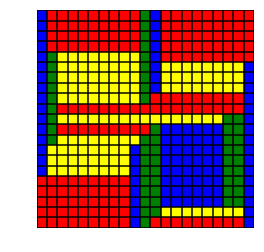

In [7]:
n, m = 21, 21
T = [shape_rectangle(1,8), shape_rectangle(8,1), shape_rectangle(1,9), shape_rectangle(9,1)]
t = len(T)
model(n, m, t, T)

Another rectangle and set of blocks. 

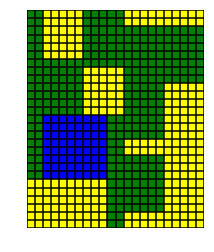

In [8]:
n, m = 22, 27
T = [shape_rectangle(8,2), shape_rectangle(5,2), shape_rectangle(1,7)]
t = len(T)
model(n, m, t, T)

Next, we consider an example with a small subset of Tetris blocks we defined earlier. These blocks are:

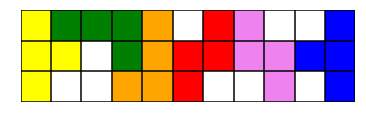

Covered area 24, best bound found 24, total board area 33


In [9]:
model(11, 3, len(shapes_tetris), shapes_tetris, noncov=[], exact=False, rep=1)

We now ask MOSEK for the maximal-area covering of a sample rectangle with holes by our Tetris blocks. You may want to enable logging to track the mixed-integer optimizer's progress.

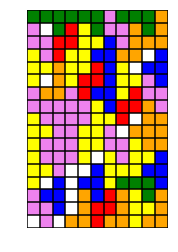

Covered area 172, best bound found 175, total board area 177


In [10]:
# Define a stream printer to grab output from MOSEK
def streamprinter(text):
    sys.stdout.write(text)
    sys.stdout.flush()
n, m = 11, 17
T = shapes_tetris
t = len(T)
noncov = [(0,0), (1,3), (9,13), (8,8), (7,7), (5,5), (4,4), (3,3), (3,1), (8,12)]
model(n, m, t, T, noncov, exact = False, rep = 0, timelimit = 20.0, logging = None)

### Combinatorial interpretation of infeasibility

In some cases the integer problem is declared as infeasible already because its linear relaxation is infeasible. This case deserves some attention in our example. The linear relaxation of the exact covering problem has the form

$$
\begin{array}{l}
Ax = b, \\
x\geq 0,
\end{array}
$$

where $A$ is the adjacency matrix discussed previously and $b$ is the characteristic vector of available positions on the board.

Standard duality for linear programing and Farkas lemma imply that a [certificate of primal infeasibility](http://docs.mosek.com/modeling-cookbook/linear.html#infeasibility-in-linear-optimization) is a vector $y$ satisfying

$$
\begin{array}{l}
A^Ty \geq 0, \\
b^Ty < 0.
\end{array}
$$

It means that an infeasibility certificate is an assignment of a real number to every position on the board so that:

* every possible placement of a single brick covers positions with non-negative sum
* the sum of all numbers on the board is negative

It is combinatorially obvious that the existence of such an assignment implies an exact covering does not exist (unfortunately not vice-versa since the covering problem is NP-hard in general; in other words integer infeasibility does not imply continuous infeasibility).

It is very easy to compute a relaxed infeasibility certificate, if one exists. All we need to do is reoptimize the task changing all integer variables to continuous ones and read off the certificate stored in the dual variables corresponding to constraints.

In [11]:
# Check if the linear relaxation is infeasible
# And if so, print the infeasibility certificate
# as a labeling of the rectangle grid.
def attemptCertificate(n, m, noncov, task):
    # Now we make the problem continuous
    task.putvartypelist(range(task.getnumvar()), [variabletype.type_cont] * task.getnumvar())
    task.optimize()
    if task.getprosta(soltype.itr) == prosta.prim_infeas:
        # Read the dual variables containing the certificate
        y = np.zeros(n * m, dtype=float)
        task.getyslice(soltype.itr, 0, n * m, y)
        for p in range(n):
            print(' '.join('    ' if (p,q) in noncov else '{: 3.1f}'.format(y[encodePos(n, m, p, q)])for q in range(m)))
        print('Certificate with sum = {0}'.format(sum(y)))
    else:
        print "No certificate found"


### Certificate example

Let us use MOSEK to solve the following [puzzle from cut-the-knot](https://www.cut-the-knot.org/blue/Defective12x12Square.shtml). Can the $12\times 12$ square with three corners removed be covered using $1\times 3$ and $3\times 1$ tiles?

We solve this problem as follows:

In [12]:
model(n = 12, m = 12,
      t = 2, T = [shape_rectangle(1,3), shape_rectangle(3,1)],
      noncov = [(0, 0), (0, 11), (11, 0)])

No covering
Looking for infeasibility certificate for the relaxation
     -1.0 -0.0  1.0 -1.0 -0.0  1.0 -1.0 -0.0  1.0 -1.0     
-1.0  1.0 -0.0 -1.0  1.0 -0.0 -1.0  1.0 -0.0 -1.0  1.0 -0.0
-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0
 1.0 -1.0 -0.0  1.0 -1.0 -0.0  1.0 -1.0 -0.0  1.0 -1.0 -0.0
-1.0  1.0 -0.0 -1.0  1.0 -0.0 -1.0  1.0 -0.0 -1.0  1.0 -0.0
-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0
 1.0 -1.0 -0.0  1.0 -1.0 -0.0  1.0 -1.0 -0.0  1.0 -1.0 -0.0
-1.0  1.0 -0.0 -1.0  1.0 -0.0 -1.0  1.0 -0.0 -1.0  1.0 -0.0
-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0  0.0  0.0 -0.0 -0.0
 1.0 -1.0 -0.0  1.0 -1.0 -0.0  1.0 -1.0  0.0  1.0 -1.0 -0.0
-1.0  1.0 -0.0 -1.0  1.0 -0.0 -1.0  1.0 -0.0 -1.0  1.0 -0.0
     -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0
Certificate with sum = -1.0


We displayed the infeasibility certificate. Every $1\times 3$ or $3\times 1$ brick covers fields with nonnegative sum (in this case, in fact, exactly $0$), while the sum of all numbers is $-1$. That proves a covering does not exist.

### Acknowledgement


Thanks to Jarosław Wróblewski for inspiring problems and discussions originating from his newsletter [Trapez](http://www.math.uni.wroc.pl/~jwr/trapez/).

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 